<a href="https://colab.research.google.com/github/TeoKets/House_Renting_Analysis/blob/master/HousesAnalysisRGBRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning the data.

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

import numpy as np
from xgboost import XGBRegressor
import sklearn

In [85]:
data=pd.read_csv("houses.csv")
data.columns

Index(['Unnamed: 0', 'title', 'price', 'price_per_sqm', 'level', 'bedrooms',
       'bathrooms', 'construction', 'region'],
      dtype='object')

column "Unamed: 0" is unnecessary and useless as it provides zero information about the houses so i need to remove it.

In [86]:
data=data.drop("Unnamed: 0",axis=1)

In [87]:
data.shape

(688, 8)

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          688 non-null    object 
 1   price          688 non-null    object 
 2   price_per_sqm  688 non-null    object 
 3   level          686 non-null    object 
 4   bedrooms       613 non-null    object 
 5   bathrooms      674 non-null    object 
 6   construction   655 non-null    float64
 7   region         688 non-null    object 
dtypes: float64(1), object(7)
memory usage: 43.1+ KB


I need to convert each column to it's proper type and clear values of unnecessary symbols.

In [89]:
data.price=data.price.str.replace(".","")
data.bedrooms=data.bedrooms.str.strip("×")
data.bathrooms=data.bathrooms.str.strip("×")
data.price=data.price.str.strip("€")
data.price_per_sqm=data.price_per_sqm.str.strip(" €/τ.μ.")

I will also split column sqm into to columns as it provides two sepeerate types of information.

In [90]:
data.rename(columns={'title': 'sqm'}, inplace=True)

In [91]:
sqm_data=data.sqm.str.split(" ")
filtered_data = [row[:2] for row in sqm_data]
df = pd.DataFrame(filtered_data, columns=['type', 'area'])
data.sqm=df.area
data["type"]=df.type


In [92]:
data=data[['region','type','price','sqm','construction','level','bedrooms','bathrooms','price_per_sqm']]
data.dropna(inplace=True)
data.sqm=data.sqm.astype(int)
data.price=data.price.astype(int)
data.price_per_sqm=data.price_per_sqm.astype(int)
data.bedrooms=data.bedrooms.astype(int)
data.bathrooms=data.bathrooms.astype(int)
data.construction=data.construction.astype(int)
data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577 entries, 0 to 687
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   region         577 non-null    object
 1   type           577 non-null    object
 2   price          577 non-null    int64 
 3   sqm            577 non-null    int64 
 4   construction   577 non-null    int64 
 5   level          577 non-null    object
 6   bedrooms       577 non-null    int64 
 7   bathrooms      577 non-null    int64 
 8   price_per_sqm  577 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 45.1+ KB


Now that i have no duplicates no null values and the types of each column are appropriate as i was inspecting my data i saw a lot of regions had very few samples so i will group them together into the general region "thessaloniki".

In [93]:
data.loc[data.region=="Θεσσαλονίκη (Καλαμαριά) ","region"]="Καλαμαριά"
data.loc[data.region=="Καλαμαριά (Νέα Ελβετία) ","region"]="Καλαμαριά"
data.loc[data.region=="Καλαμαριά ","region"]="Καλαμαριά"
region_data = data.groupby("region")["region"].transform("count")
data.loc[region_data<7,"region"]="Θεσσαλονίκη"
region_data=data.groupby("region").count()
region_data
data

,region,type,price,sqm,construction,level,bedrooms,bathrooms,price_per_sqm
0,Θεσσαλονίκη (Κέντρο),Διαμέρισμα,1080,120,1970,2ος,3,1,9
1,Θεσσαλονίκη (Ανάληψη),Διαμέρισμα,650,50,1980,1ος,1,1,13
2,Θεσσαλονίκη (Φάληρο),Διαμέρισμα,530,70,1970,Ημιώροφος,2,1,8
3,Θεσσαλονίκη (Ανω Πόλη),Διαμέρισμα,430,57,1998,Ημιώροφος,1,1,8
4,Θεσσαλονίκη (Κέντρο),Διαμέρισμα,650,50,1960,Ημιώροφος,1,1,13
...,...,...,...,...,...,...,...,...,...
683,Θεσσαλονίκη,Μονοκατοικία,550,100,1980,Ισόγειο,3,1,6
684,Καλαμαριά,Μεζονέτα,650,117,1986,3ος,3,1,6
685,Καλαμαριά,Διαμέρισμα,440,37,1988,1ος,1,1,12
686,Θεσσαλονίκη,Διαμέρισμα,550,78,1998,Ημιώροφος,2,1,7


I will convert the level from words to numbers to be easier for my model to use it.

In [94]:
data.loc[data.level=="1ος","level"]=1
data.loc[data.level=="2ος","level"]=2
data.loc[data.level=="3ος","level"]=3
data.loc[data.level=="4ος","level"]=4
data.loc[data.level=="5ος","level"]=5
data.loc[data.level=="6ος","level"]=6
data.loc[data.level=="7ος","level"]=7
data.loc[data.level=="8ος","level"]=8
data.loc[data.level=="Ημιώροφος","level"]=1.5
data.loc[data.level=="Ισόγειο","level"]=0
data.loc[data.level=="Ημιυπόγειο","level"]=-0.5
data.loc[data.level=="Υπερυψωμένο","level"]=0.5

data.groupby("level").count()


,region,type,price,sqm,construction,bedrooms,bathrooms,price_per_sqm
level,,,,,,,,
-0.5,20,20,20,20,20,20,20,20
0.0,57,57,57,57,57,57,57,57
0.5,2,2,2,2,2,2,2,2
1.0,139,139,139,139,139,139,139,139
1.5,37,37,37,37,37,37,37,37
2.0,94,94,94,94,94,94,94,94
3.0,72,72,72,72,72,72,72,72
4.0,48,48,48,48,48,48,48,48
5.0,35,35,35,35,35,35,35,35


Now that every data type is correct and generally data is clean its time to look more carefully what the values are!

# Inspect the data

In [95]:
data.describe()

,price,sqm,construction,bedrooms,bathrooms,price_per_sqm
count,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000
mean,672.729636,65.890815,1980.634315,1.599653,1.051993,11.166378
std,381.062968,35.434900,16.552517,0.786739,0.237318,4.245101
min,250.000000,15.000000,1900.000000,1.000000,1.000000,5.000000
25%,450.000000,40.000000,1970.000000,1.000000,1.000000,8.000000
50%,600.000000,56.000000,1976.000000,1.000000,1.000000,10.000000
75%,750.000000,82.000000,1990.000000,2.000000,1.000000,13.000000
max,4500.000000,350.000000,2025.000000,8.000000,3.000000,50.000000


<hr>
Between 75% and max there is a huge gap so this seems problematic lets make a boxplot to see if there are outliers.
<hr>

<Axes: ylabel='price'>

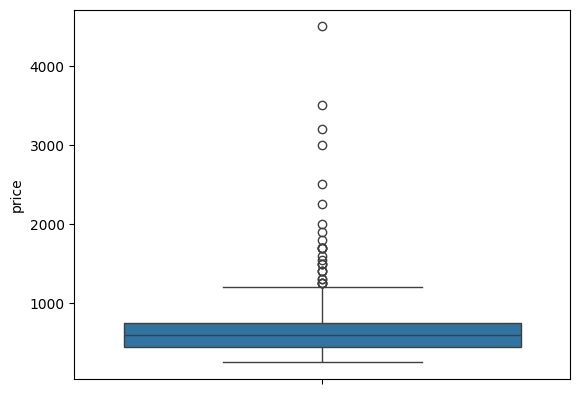

In [96]:
sns.boxplot(data.price)

It appears that there is a significant amount of outliers manipulating the data,due to luxury houses. That is why i chose to analyse this category seperately.

In [97]:
luxury_threshold = data['price'].quantile(0.85)
data_luxury=data.loc[data.price>luxury_threshold]
data_normal=data.loc[data.price<=luxury_threshold]

Now let's see what is the cheapest average price in each region.

In [98]:
data_normal.groupby("region").price.mean().sort_values(ascending=True)

,price
region,
Πυλαία,485.000000
Θεσσαλονίκη (Ανω Πόλη),501.923077
Θεσσαλονίκη (Βαρδάρη),520.263158
Θεσσαλονίκη (Χαριλάου),535.833333
Θεσσαλονίκη (Ανω Τούμπα),539.500000
Θεσσαλονίκη (40 Εκκλησιές),540.384615
Θεσσαλονίκη (Φάληρο),541.951220
Θεσσαλονίκη (Ξηροκρήνη),543.333333
Θεσσαλονίκη (Ανάληψη),545.272727


In [99]:
data_luxury.groupby("region").price.mean().sort_values(ascending=True)

,price
region,
Θεσσαλονίκη (Χαριλάου),975.000000
Θεσσαλονίκη (Βαρδάρη),1000.000000
Πυλαία,1006.666667
Θεσσαλονίκη (Κάτω Τούμπα),1050.000000
Θεσσαλονίκη (Ανω Πόλη),1150.000000
Θεσσαλονίκη (Ανάληψη),1157.142857
Θεσσαλονίκη (Πανεπιστήμια),1266.666667
Θεσσαλονίκη (Κέντρο),1314.102564
Θεσσαλονίκη (Φάληρο),1325.000000


# Visualise


Time to visualise the relationships between our columns.


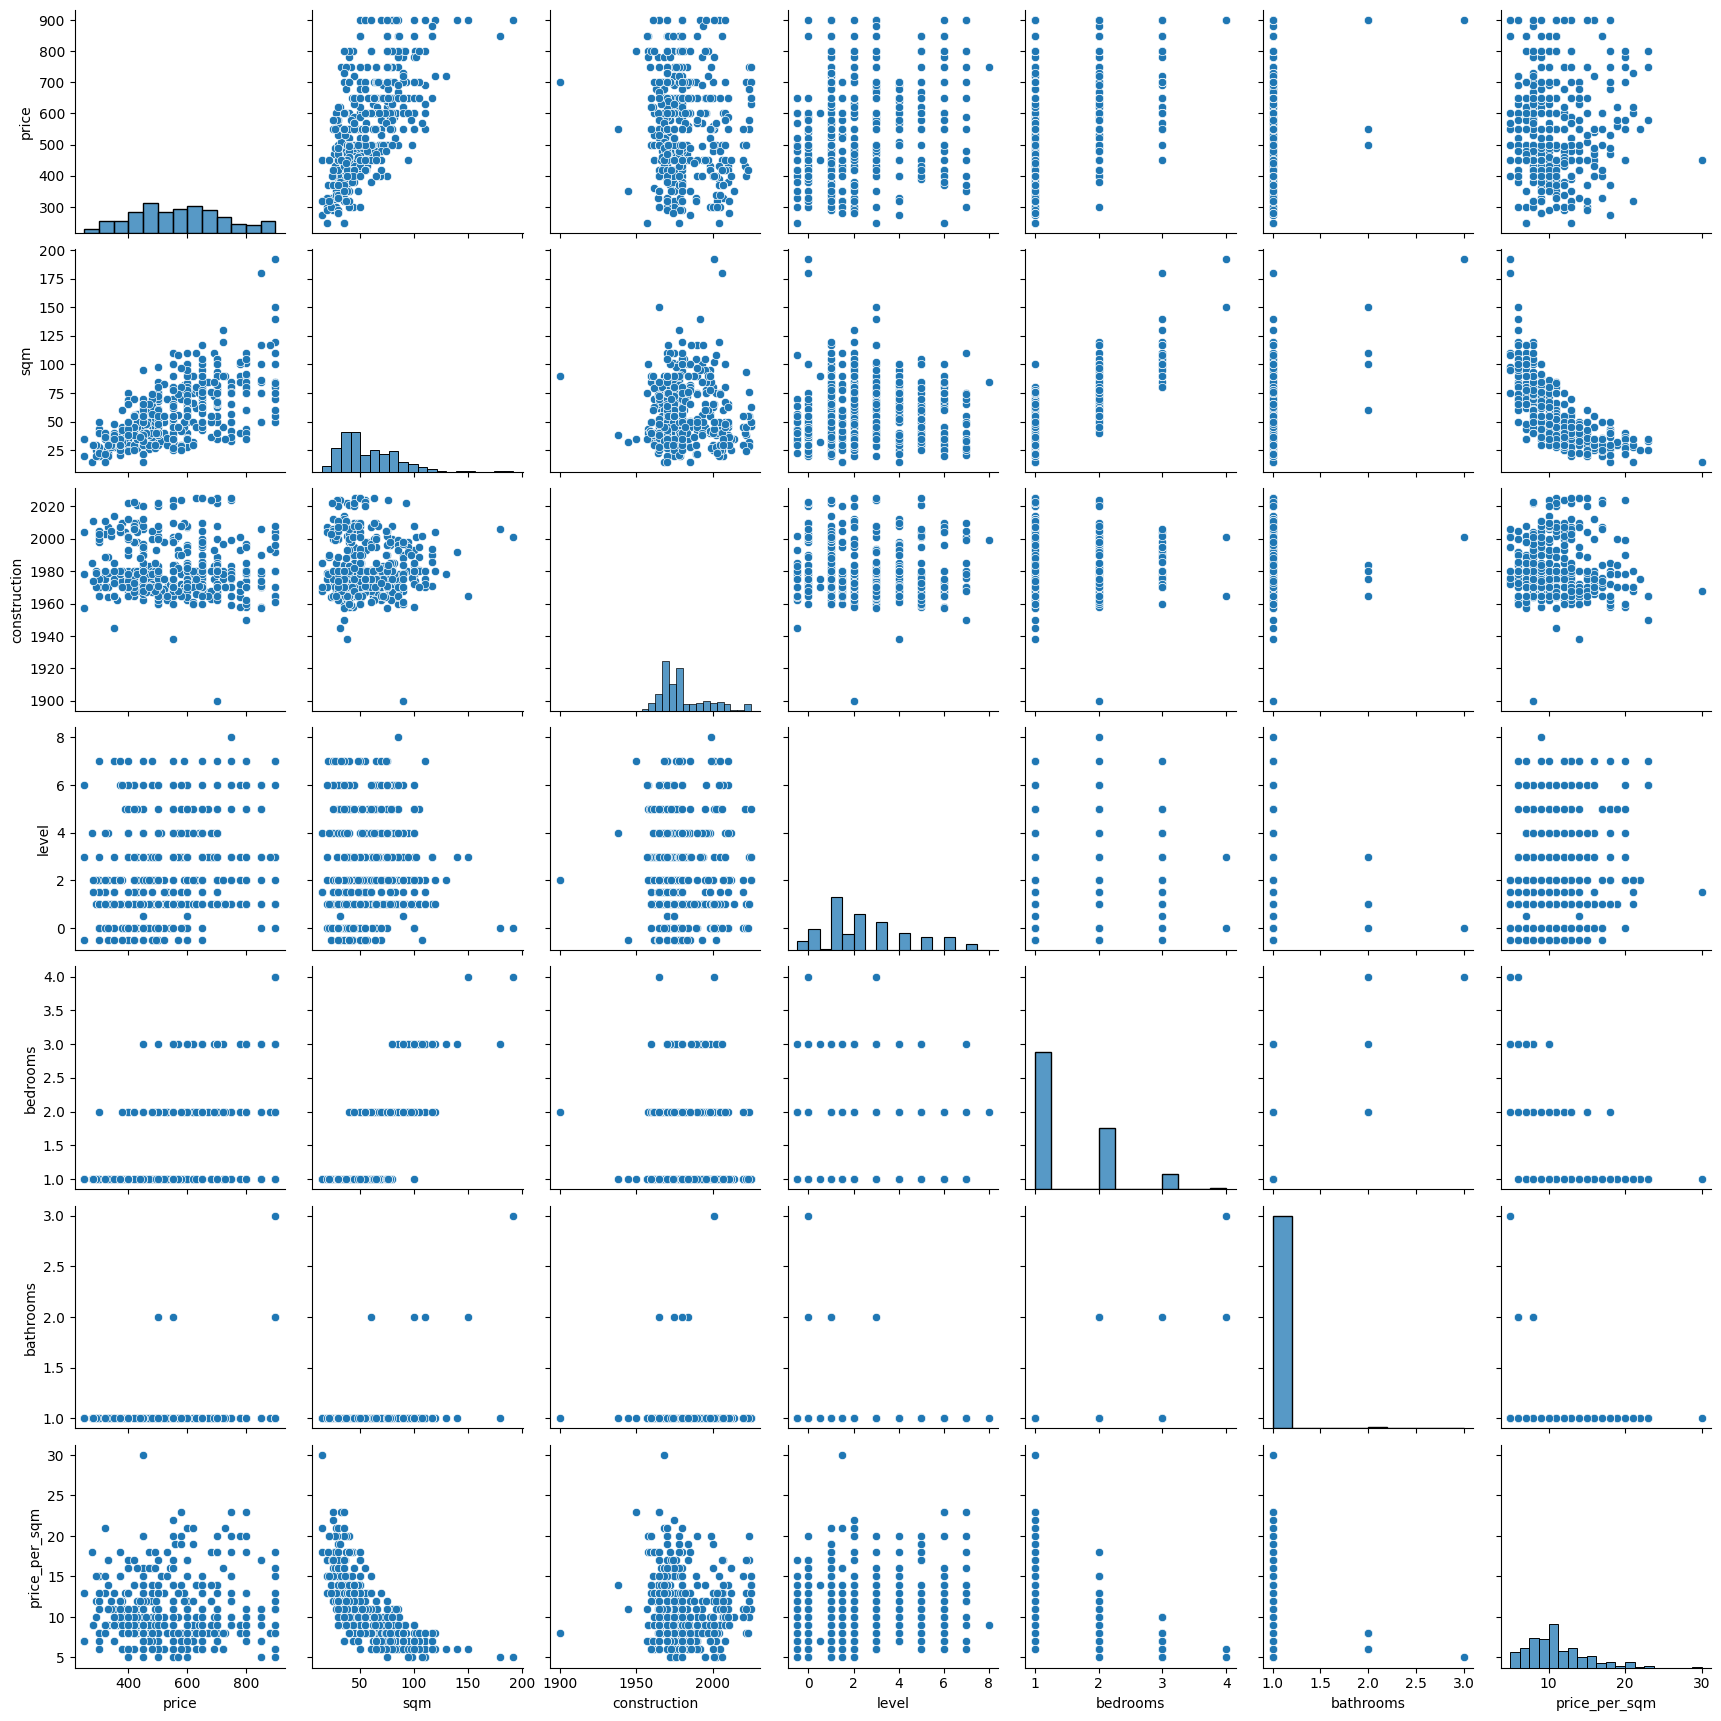

In [100]:
sns.pairplot(data_normal)

Price with square meters seems to have a linear relationship from the diagrams.

In [101]:
px.scatter(data_normal,x="sqm",y="price" ,trendline='ols')

the trendline indicates a positive relationship between price and square meters.

In [102]:
pearson_corr=data_normal.sqm.corr(data.price,method="pearson")
spearman_corr=data_normal.sqm.corr(data.price,method="spearman")
print(f"Pearson correlation: {pearson_corr}")
print(f"Spearman correlation: {spearman_corr}")

Pearson correlation: 0.6328847448394705
Spearman correlation: 0.6411617301086187


we have both a positive linear and monotonic relationship indicating strong correlation.



# Creating a RGBRegressor model for predicting renting prices in thessaloniki.


In [103]:
features=data_normal.drop(["price","price_per_sqm"],axis=1)
features=features.fillna('Unknown')

for col in features.columns:
    if features[col].dtype == 'object':
        features[col] = features[col].astype('category')
features = pd.get_dummies(features, drop_first=True)

target=data_normal.price
scaler = StandardScaler()
X_train, X_test, y_train, y_test=sklearn.model_selection.train_test_split(features,target,test_size=0.2,random_state=42)

/tmp/ipython-input-2245284281.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [104]:
features.head()

,sqm,construction,level,bedrooms,bathrooms,region_Θεσσαλονίκη (40 Εκκλησιές),region_Θεσσαλονίκη (Ανάληψη),region_Θεσσαλονίκη (Ανω Πόλη),region_Θεσσαλονίκη (Ανω Τούμπα),region_Θεσσαλονίκη (Βαρδάρη),...,region_Θεσσαλονίκη (Ντεπώ),region_Θεσσαλονίκη (Ξηροκρήνη),region_Θεσσαλονίκη (Πανεπιστήμια),region_Θεσσαλονίκη (Παπάφειο),region_Θεσσαλονίκη (Φάληρο),region_Θεσσαλονίκη (Χαριλάου),region_Καλαμαριά,region_Πυλαία,type_Μεζονέτα,type_Μονοκατοικία
1,50,1980,1.0,1,1,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,70,1970,1.5,2,1,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,57,1998,1.5,1,1,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,50,1960,1.5,1,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,70,1965,2.0,2,1,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [113]:
params = {
    'n_estimators': [200, 400, 600,800,1000],
    'max_depth': [2,3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'random_state': [42,64,100,124]
}


xgb = XGBRegressor()
search = RandomizedSearchCV(xgb, params, n_iter=15, cv=5, scoring='r2', verbose=1)
search.fit(features, target)

print("Best R²:", search.best_score_)
print("Best Params:", search.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best R²: 0.45673983097076415
Best Params: {'subsample': 0.8, 'random_state': 64, 'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [115]:
model=XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=100
)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


R² Score: 0.399
MAE: 85.75
RMSE: 107.78
